In [3]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [4]:
DATA_DIR = '.\stanford-dataset'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[['image_id', 'image_path', 'label_colored_path']]
metadata_df['image_path'] = metadata_df['image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['label_colored_path'] = metadata_df['label_colored_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(643, 72)

In [5]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'labels_class_dict.csv'))
# Get class names
class_names = class_dict['class_names'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown']
Class RGB values:  [[68, 1, 84], [72, 40, 140], [62, 74, 137], [38, 130, 142], [31, 158, 137], [53, 183, 121], [109, 205, 89], [180, 222, 44], [49, 104, 142]]


In [6]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown']
Class RGB values:  [[68, 1, 84], [72, 40, 140], [62, 74, 137], [38, 130, 142], [31, 158, 137], [53, 183, 121], [109, 205, 89], [180, 222, 44], [49, 104, 142]]


In [7]:
# Creation of the test_set and the valid_set as paths

train_images_paths = train_df['image_path'].tolist()
train_masks_paths = train_df['label_colored_path'].tolist()

valid_images_paths = valid_df['image_path'].tolist()
valid_masks_paths = valid_df['label_colored_path'].tolist()
valid_images_paths

['.\\stanford-dataset\\images/6000243.jpg',
 '.\\stanford-dataset\\images/5000129.jpg',
 '.\\stanford-dataset\\images/6000000.jpg',
 '.\\stanford-dataset\\images/6000197.jpg',
 '.\\stanford-dataset\\images/6000172.jpg',
 '.\\stanford-dataset\\images/6000203.jpg',
 '.\\stanford-dataset\\images/6000288.jpg',
 '.\\stanford-dataset\\images/6000170.jpg',
 '.\\stanford-dataset\\images/0000631.jpg',
 '.\\stanford-dataset\\images/6000077.jpg',
 '.\\stanford-dataset\\images/9005011.jpg',
 '.\\stanford-dataset\\images/6000201.jpg',
 '.\\stanford-dataset\\images/3001569.jpg',
 '.\\stanford-dataset\\images/3000323.jpg',
 '.\\stanford-dataset\\images/6000313.jpg',
 '.\\stanford-dataset\\images/6000166.jpg',
 '.\\stanford-dataset\\images/6000289.jpg',
 '.\\stanford-dataset\\images/3000119.jpg',
 '.\\stanford-dataset\\images/5000257.jpg',
 '.\\stanford-dataset\\images/5000200.jpg',
 '.\\stanford-dataset\\images/1100009.jpg',
 '.\\stanford-dataset\\images/6000058.jpg',
 '.\\stanford-dataset\\images/01

In [8]:
# helper function for data visualization
def visualize(**images):

    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):

    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):

    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [9]:
class BackgroundDataset(torch.utils.data.Dataset):

    
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['label_colored_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [10]:
def DataGenerator(images_paths, masks_paths, batch_size=10):
    while True :
        for i in range(0, len(images_paths), batch_size):
            #batch_files = df_path[i : i+batch_size]
            imgs=[]
            masks=[]
            for j in range(i,i+batch_size):
            #for file in batch_files:
                #file = random.sample(files,1)[0]
                #image = cv2.cvtColor(cv2.resize(cv2.imread(images_paths[j]),(320,320)),cv2.COLOR_RGB2BGR)
                image = cv2.resize(cv2.imread(images_paths[j]),(320,320))  #incase of size change
                mask = cv2.cvtColor(cv2.resize(cv2.imread(masks_paths[j]),(320,320)),cv2.COLOR_RGB2BGR)
                mask = one_hot_encode(mask, class_rgb_values).astype('float')
                imgs.append(image)
                masks.append(mask)
                
            yield np.array(imgs), np.array(masks)   

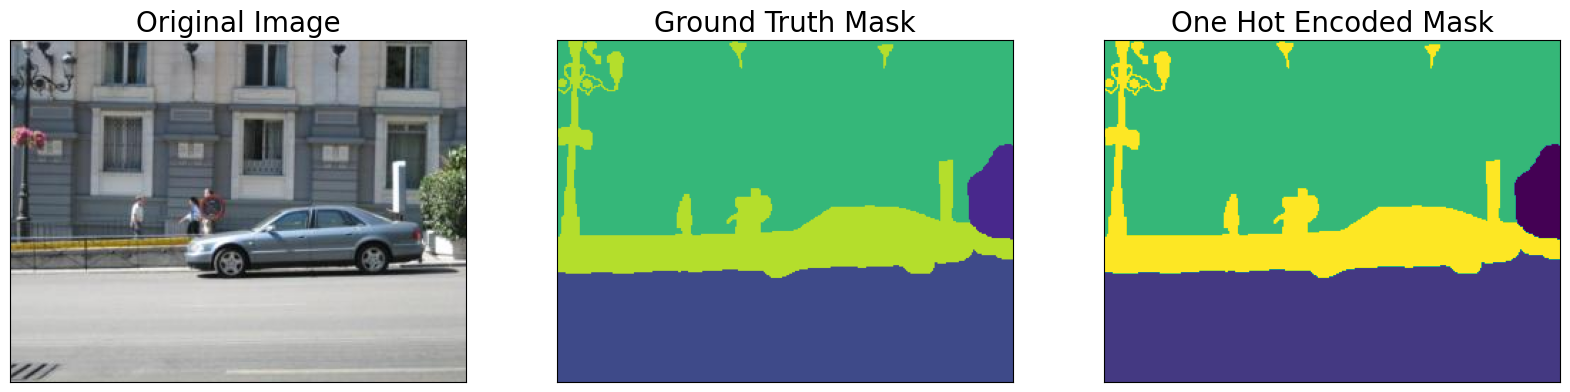

In [11]:
dataset = BackgroundDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [12]:
def get_training_augmentation():
    train_transform = [
        album.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.5,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():

    test_transform = [
        album.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

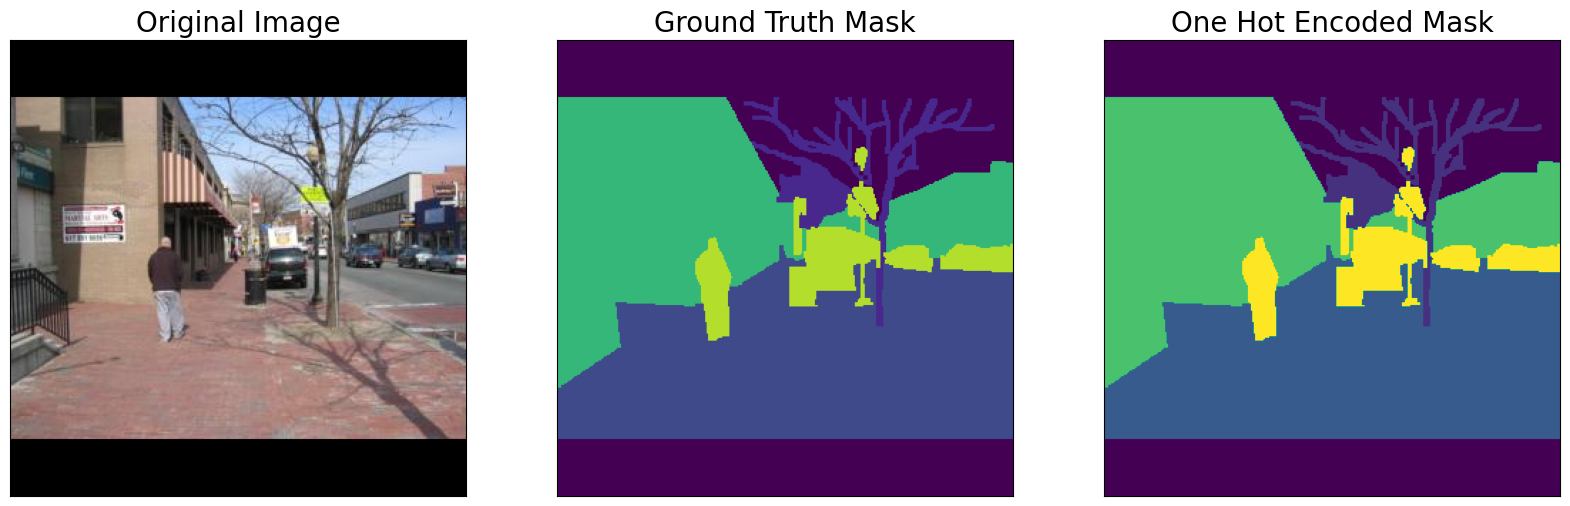

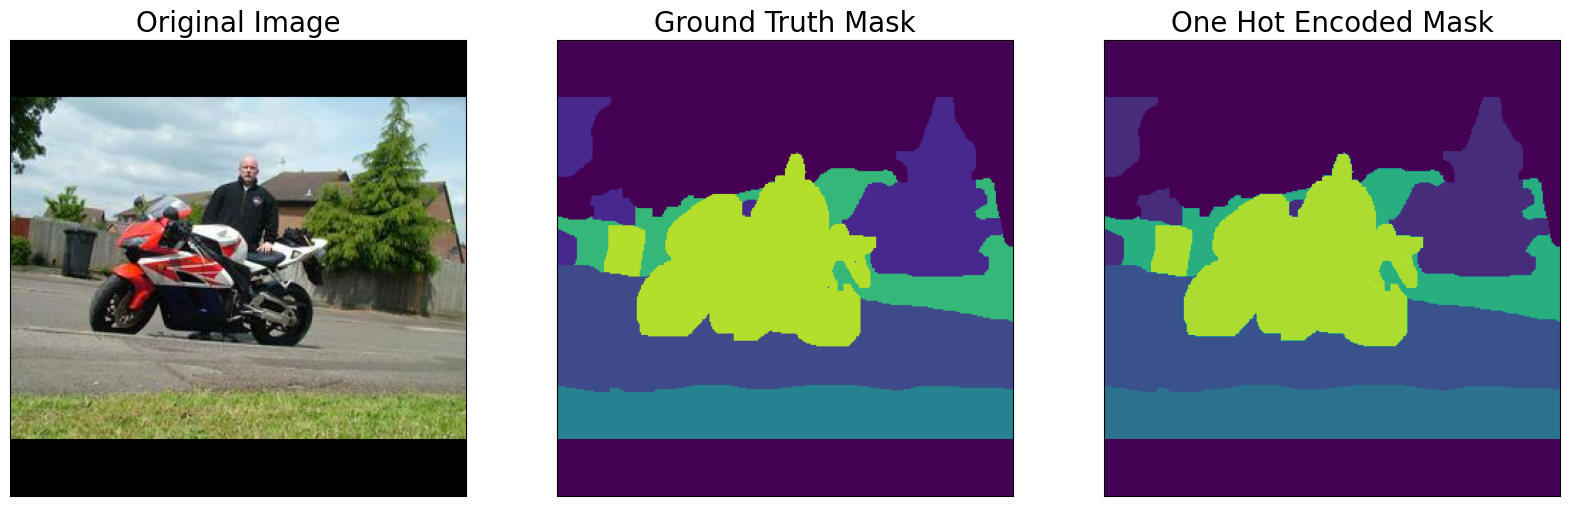

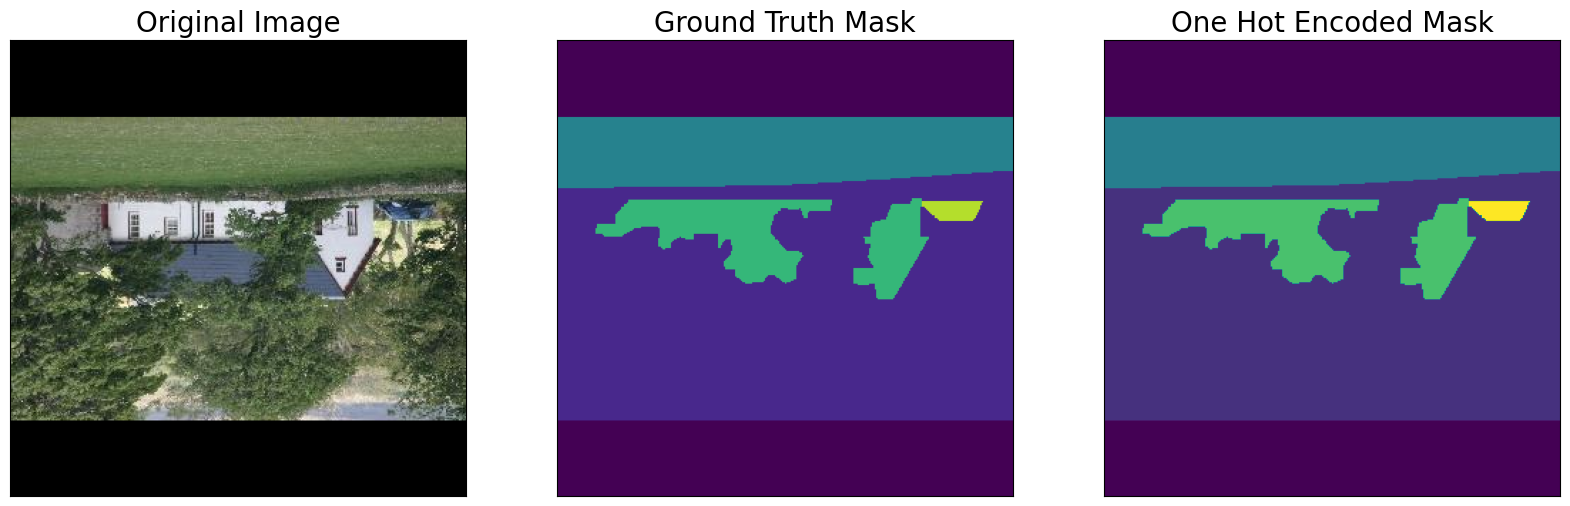

In [13]:
augmented_dataset = BackgroundDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)



for idx in range(3):
    random_idx = random.randint(0, len(augmented_dataset)-1)
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [14]:
image, mask = augmented_dataset[random_idx]
image.shape

(320, 320, 3)

In [15]:
# train_set generator and valid_set generaor
train_gen = DataGenerator(train_images_paths[:-3], train_masks_paths[:-3])
valid_gen = DataGenerator(valid_images_paths[:-2], valid_masks_paths[:-2])

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [17]:
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from tensorflow.keras.utils import plot_model,load_img,img_to_array, array_to_img
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
from keras.callbacks import ModelCheckpoint

In [18]:
# Load the MobileNetV3 model

base_model = MobileNetV3Large(include_top=False,input_shape=(320, 320, 3))

# Add additional convolution layers to increase the receptive field
x = base_model.output

#Splitting the output of MobileNet V3 into two and applying different upscaling procedures

# x2 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x) #first split to 1x1 conv
# x2= Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu')(x2)

#Old Model Architecture(still works)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    
# # Add upsampling layers to increase the resolution of the output
x = Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
x= MaxPool2D(pool_size=(2,2),padding='same')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(filters=9, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)


# x3= base_model.layers[7].output #Layer 7 from MobileNetV3

# #Second section/split
# x4=UpSampling2D()(x)
# x4= AveragePooling2D(pool_size=(2,2),padding='same')(x4)
# x4=Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu')(x4)
# x4=BatchNormalization()(x4)
# x4=Activation('sigmoid')(x4)
# x4=UpSampling2D(interpolation='bilinear')(x4)

# x=concatenate([UpSampling2D(interpolation='bilinear')(x2),x4],axis=-1) #concatenate the two sections

# #Upsample until the same shape as x3 is achieved
# x=Conv2DTranspose(filters=64,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same')(x)
# x=BatchNormalization()(x)
# x=Conv2DTranspose(filters=32,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same')(x)
# x=BatchNormalization()(x)
# x=Conv2DTranspose(filters=16,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same')(x)
# x=BatchNormalization()(x)

# #concatenate x with x3 and upsample until the same shape as input is achieved (224,224)
# x=concatenate([x,x3],axis=-1)

# #9 filters are for the 9 class labels. Necessary
x=Conv2DTranspose(filters=9,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same')(x)

#softmax activation at the end
x = Activation('softmax')(x)

    
# Define the model
model = Model(inputs=base_model.input, outputs=x)


# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 320, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 160, 160, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [19]:
from keras import backend as K

In [20]:
def dice_coef(y_true, y_pred): 
    
    epsilon=1e-6
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    
    return K.mean((numerator + epsilon) / (denominator + epsilon))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [21]:
model.compile(loss=dice_coef_loss, optimizer='adam', metrics=["accuracy",dice_coef])

In [22]:
filepath='./MODEL/bestmodel1.hdf5'
model=load_model(filepath=filepath,compile=False)
model.compile(loss=dice_coef_loss, optimizer='adam', metrics=["accuracy",dice_coef])

In [23]:
#early_stop = EarlyStopping(monitor='dice_coef',restore_best_weights=True) #early stopping if performance of network does not improve
mcp= ModelCheckpoint(filepath=filepath,monitor='dice_coef',mode='max',save_best_only=True)
epochs = 10
batch_size = 32

history = model.fit(train_gen,
                epochs = epochs,
                steps_per_epoch=len(train_images_paths)//batch_size,
                validation_data=valid_gen,
                validation_steps=len(valid_images_paths)//batch_size,
                callbacks=[mcp])

Epoch 1/10
20/20 [==============================] - 64s 3s/step - loss: 0.5029 - accuracy: 0.9253 - dice_coef: 0.4971 - val_loss: 0.6063 - val_accuracy: 0.7817 - val_dice_coef: 0.3937
Epoch 2/10
20/20 [==============================] - 52s 3s/step - loss: 0.5117 - accuracy: 0.9224 - dice_coef: 0.4883 - val_loss: 0.5993 - val_accuracy: 0.8170 - val_dice_coef: 0.4007
Epoch 3/10
20/20 [==============================] - 54s 3s/step - loss: 0.4944 - accuracy: 0.9223 - dice_coef: 0.5056 - val_loss: 0.5979 - val_accuracy: 0.8217 - val_dice_coef: 0.4021
Epoch 4/10
20/20 [==============================] - 53s 3s/step - loss: 0.5041 - accuracy: 0.9294 - dice_coef: 0.4959 - val_loss: 0.6036 - val_accuracy: 0.7942 - val_dice_coef: 0.3964
Epoch 5/10
20/20 [==============================] - 53s 3s/step - loss: 0.5021 - accuracy: 0.9300 - dice_coef: 0.4979 - val_loss: 0.5770 - val_accuracy: 0.8477 - val_dice_coef: 0.4230
Epoch 6/10
20/20 [==============================] - 53s 3s/step - loss: 0.4951 -

Text(0.5, 1.0, 'Accuracy')

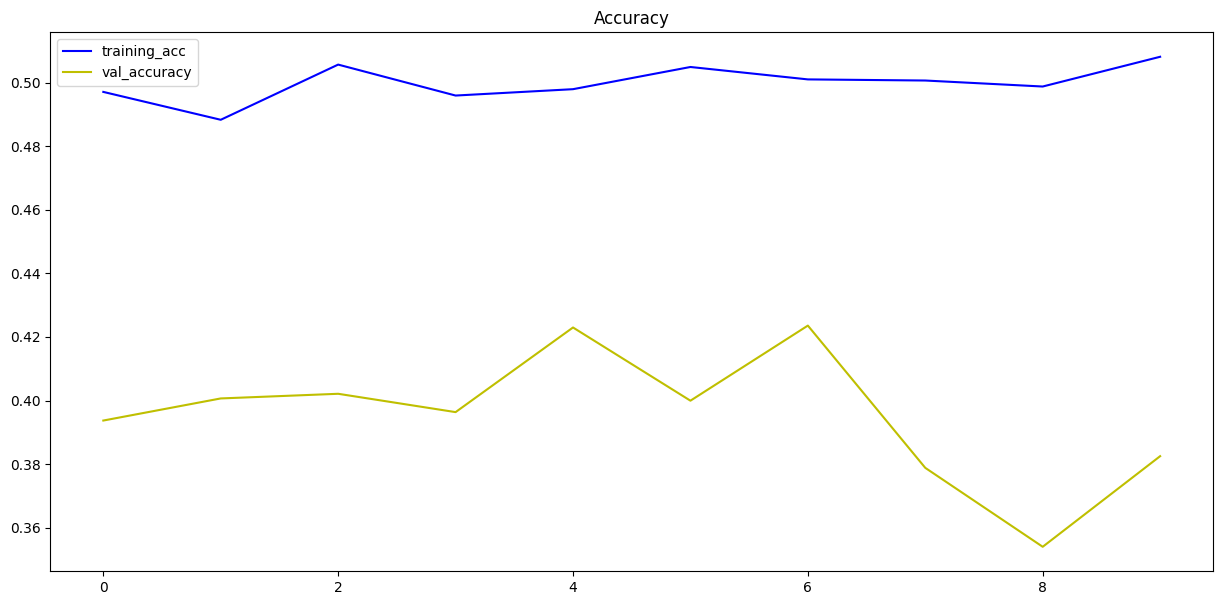

In [24]:
plt.figure(figsize=[15,7])
plt.plot(history.history['dice_coef'],'b')
plt.plot(history.history['val_dice_coef'],'y')
plt.legend(['training_acc','val_accuracy'])
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

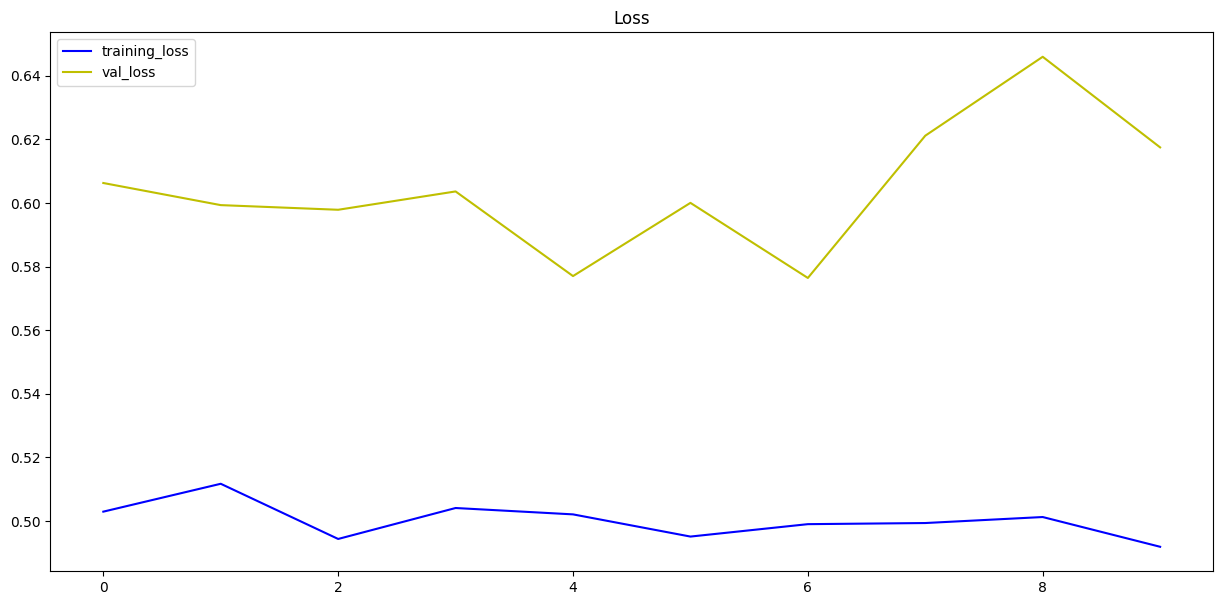

In [25]:
plt.figure(figsize=[15,7])
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'y')
plt.legend(['training_loss','val_loss'])
plt.title('Loss')

In [26]:
model=load_model(filepath,compile=False)
model.compile(loss=dice_coef_loss, optimizer='adam', metrics=["accuracy",dice_coef])

1/1 [==============================] - 2s 2s/step


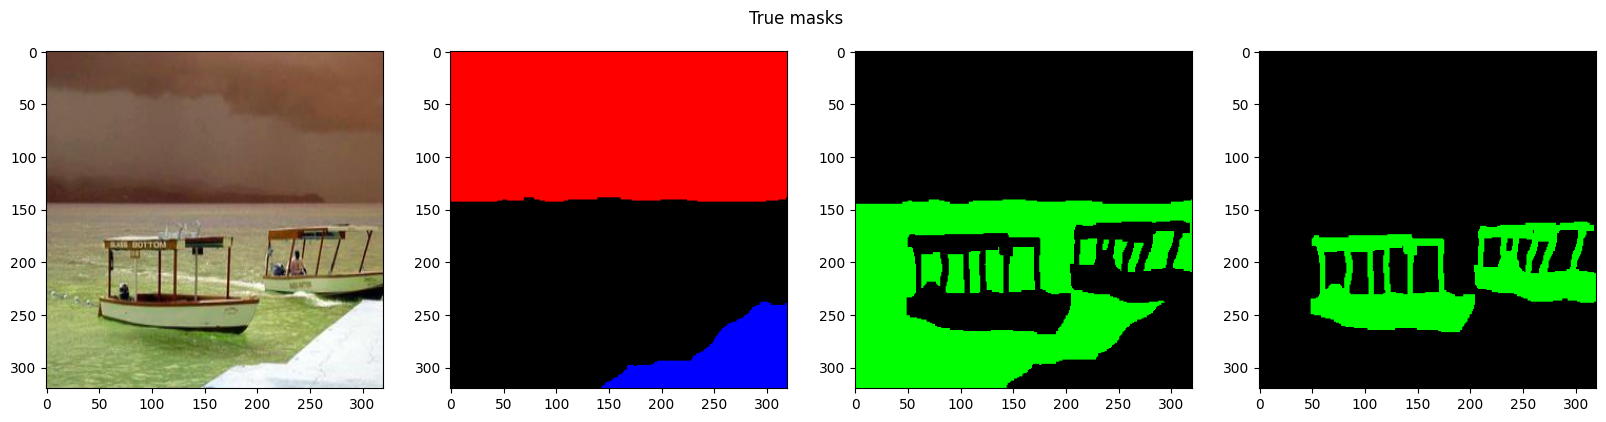

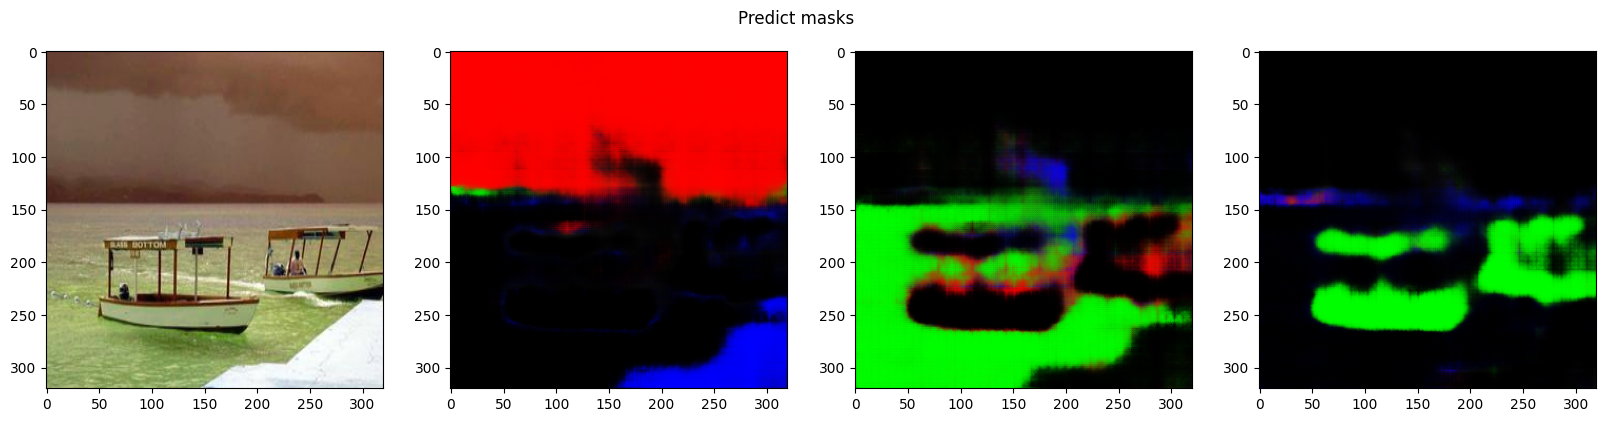

In [27]:
imgs, masks = next(valid_gen)

plt.figure(figsize=(20, 20))
plt.suptitle('True masks', x = 0.5, y = 0.6)
ax = plt.subplot(1, 4, 1)
ax.imshow(imgs[0])
for i in range(3):
    ax = plt.subplot(1, 4, i + 2)
    ax.imshow(masks[0,:,:,3*i:3*i+3])

predict_mask = model.predict(imgs)

plt.figure(figsize=(20, 20))
plt.suptitle('Predict masks', x = 0.5, y = 0.6)
ax = plt.subplot(1, 4, 1)
ax.imshow(imgs[0])
for i in range(3):
    ax = plt.subplot(1, 4, i + 2)
    ax.imshow(predict_mask[0,:,:,3*i:3*i+3])


In [32]:
np.shape(predict_mask)

(10, 320, 320, 9)

1/1 [==============================] - 3s 3s/step


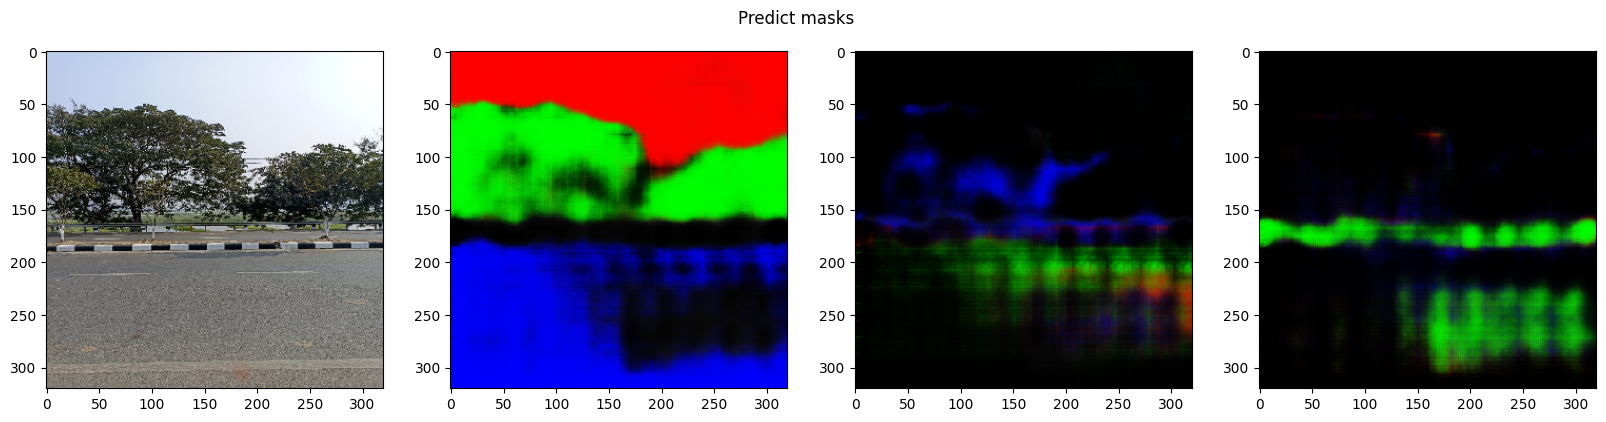

In [ ]:
def convertimg(path):
    imgarr=[]
    im = cv2.resize(cv2.imread(path),(320,320))  #incase of size change
    imgarr.append(im)
    yield np.array(imgarr) 

image_test= r"./testimg/9.jpg" #PATH FOR NEW IMAGES. Change the image name to change img
im2=convertimg(image_test) #generator for resizing and convert to np.array
im=cv2.resize(cv2.imread(image_test),(320,320))
img_test=np.array(im)

predict_new = model.predict(im2) #get segmented masks 

# ax2= plt.subplot(1, 2, 1)
# ax2.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))

# ax2 = plt.subplot(1, 2, 2)
# ax.imshow(imgs[0])
# for i in range(1):
#     ax2.imshow(predict_new[0,:,:,3*i:3*i+3])

#VISUALIZATION
plt.figure(figsize=(20, 20))
plt.suptitle('Predict masks', x = 0.5, y = 0.6)
ax2 = plt.subplot(1, 4, 1)
ax2.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
for i in range(3):
    ax2 = plt.subplot(1, 4, i + 2)
    ax2.imshow(predict_new[0,:,:,3*i:3*i+3])

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob

import IPython.display as ipd
from tqdm import tqdm

import subprocess

plt.style.use('ggplot')

In [ ]:
def convertimg(path):
    imgarr=[]
    im = cv2.resize(path,(320,320))  #incase of size change
    imgarr.append(im)
    yield np.array(imgarr) 

In [ ]:
# fig, axs = plt.subplots(5, 5, figsize=(30, 20))
# axs = axs.flatten()

cap = cv2.VideoCapture("026c7465-309f6d33.mp4")
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

img_idx = 0
i=0
for frame in range(n_frames):
    ret, img = cap.read()
    if ret == False:
        break
    if frame % 1 == 0:
        # axs[img_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # axs[img_idx].set_title(f'Frame: {frame}')
        # axs[img_idx].axis('off')
        # img_idx += 1
        im=convertimg(img) #generator for resizing and convert to np.array
        img_test=np.array(im)
        predict_new = model.predict(im)
        imagepath='./Predicted_images/seg_img'
        image1=predict_new[0,:,:,:3]
        image1=(image1*255).astype(np.uint8)
        plt.imsave(imagepath+str(i)+'.png',image1)
        i+=1

plt.tight_layout()
plt.show()
cap.release()

1/1 [==============================] - 0s 96ms/step


<Figure size 640x480 with 0 Axes>

In [ ]:
ipd.Video('026c7465-309f6d33.mp4', width=320,height=320)

In [ ]:
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")

Returned True and img of shape (720, 1280, 3)
1/1 [==============================] - 0s 153ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


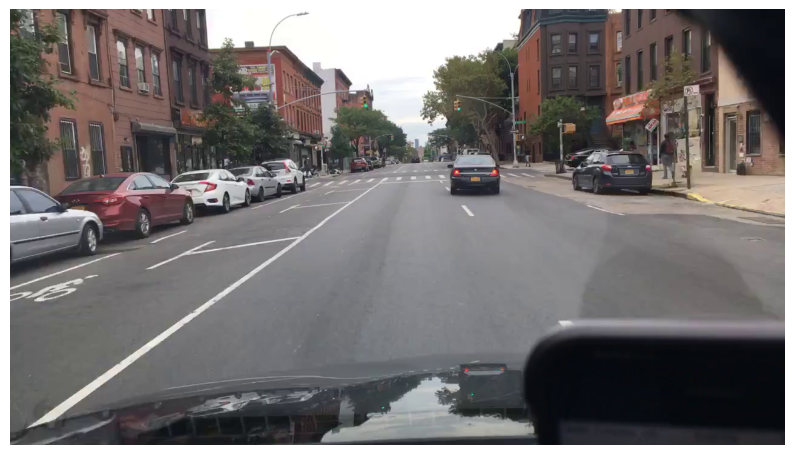

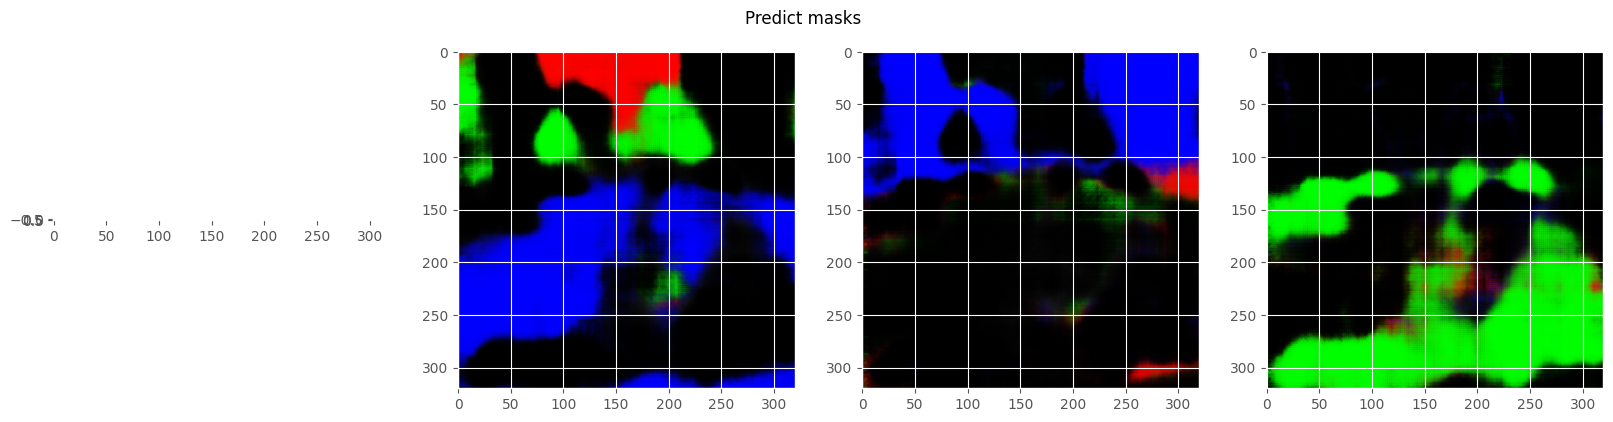

In [ ]:
cap = cv2.VideoCapture('026c7465-309f6d33.mp4')
ret, img = cap.read()
print(f'Returned {ret} and img of shape {img.shape}')
display_cv2_img(img)
def convertimg(path):
    imgarr=[]
    im = cv2.resize(path,(320,320))  #incase of size change
    imgarr.append(im)
    yield np.array(imgarr) 

image_test= img

#PATH FOR NEW IMAGES. Change the image name to change img
im=convertimg(img) #generator for resizing and convert to np.array
# im=cv2.resize(image_test,(10,320,320))
img_test=np.array(im)

predict_new = model.predict(im) 

plt.figure(figsize=(20, 20))
plt.suptitle('Predict masks', x = 0.5, y = 0.6)
ax2 = plt.subplot(1, 4, 1)
ax2.imshow(cv2.cvtColor(predict_new, cv2.COLOR_BGR2RGB))
for i in range(3):
    ax2 = plt.subplot(1, 4, i + 2)
    ax2.imshow(predict_new[0,:,:,3*i:3*i+3])

In [ ]:

image1=predict_new[0,:,:,:3]
image1=(image1*255).astype(np.uint8)
plt.imsave('test.png',image1)

In [ ]:
def add_annotations(img, frame, video_labels):
    max_frame = video_labels.query("video_frame <= @frame")["video_frame"].max()
    frame_labels = video_labels.query("video_frame == @max_frame")
    for i, d in frame_labels.iterrows():
        pt1 = int(d["box2d.x1"]), int(d["box2d.y1"])
        pt2 = int(d["box2d.x2"]), int(d["box2d.y2"])
        color = color_map[d["category"]]
        img = cv2.rectangle(img, pt1, pt2, color, 3)
    return img

In [ ]:
def convertimg(path):
    imgarr=[]
    im = cv2.resize(path,(320,320))  #incase of size change
    imgarr.append(im)
    yield np.array(imgarr) 
    
VIDEO_CODEC = 'XVID'
fps = 59.94
width = 320
height = 320
out = cv2.VideoWriter("out_test.avi",
                cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                fps,
                (width, height))

# cap = cv2.VideoCapture("026c7465-309f6d33.mp4")
# n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# for frame in tqdm(range(n_frames), total=n_frames):
    # ret, img = cap.read()
    # if ret == False:
    #     break

    # img = cap.read() #PATH FOR NEW IMAGES. Change the image name to change img
    # im2=convertimg(img) #generator for resizing and convert to np.array
    # im=cv2.resize(img,(320,320))
    # img_test=np.array(im)

    # predict_new = model.predict(im2)
i=0
imgarr=[]
for root,dirs, files in os.walk('./Predicted_images'):
    for file in files:
        inimg=cv2.imread('./Predicted_images/'+file)
        out.write(inimg)
    
out.release()

In [ ]:
# from IPython.display import HTML
# HTML("""
# <video width=320 controls>
# <source src="./out_test.mp4" type="video/mp4">
# </video>
# """)

In [ ]:
ipd.Video('./out_test.mov',width=320,height=320)